### imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill
import datetime

import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import shap
from shap_flow_util import (
    read_csv_incl_timeindex,
    get_mean_shap_attr,
    plot_dependency, 
    read_csv_incl_timeindex, 
    rename_nodes_in_graph_FR, 
    save_graph_thesis, 
    plot_bar_mean_abs_asv,
    plot_bar_mean_abs_shap
)

# load credit flow, models, etc.

In [3]:
# load credit flow and models from file
periods = [('2015-01-08', '2021-09-30'), # pre energy-crisis
                ('2021-10-01', '2023-12-31'), # energy crisis
                ('2015-01-08', '2023-12-31')] # full period
version = 'v5'
date = datetime.datetime.now().strftime("%Y-%m-%d")

creditflow_list = []
model_list = []
fg_list = []
bg_list = []
for (start_date, end_date) in periods:
    cf_file_name = 'flow_xgb_start_{}_end_{}'.format(start_date, end_date, version)
    with open('./credit_flow/{}/{}.pkl'.format(version, cf_file_name), 'rb') as file:
        loaded_cf = dill.load(file)
        rename_nodes_in_graph_FR(loaded_cf)
        creditflow_list.append(loaded_cf)

    model = xgb.Booster()
    model_name = 'xgb_start_{}_end_{}_best'.format(start_date, end_date)
    model.load_model("./models/{}/{}.json".format(version, model_name))
    model_list.append(model)
    fg_list.append(read_csv_incl_timeindex('./data/{}/fg_xgb_start_{}_end_{}.csv'.format(version, start_date, end_date)))
    bg_list.append(read_csv_incl_timeindex('./data/{}/bg_xgb_start_{}_end_{}.csv'.format(version, start_date, end_date)))

# Shapley flow

## Plots of mean absolute credit

### Mean absolute edge credit

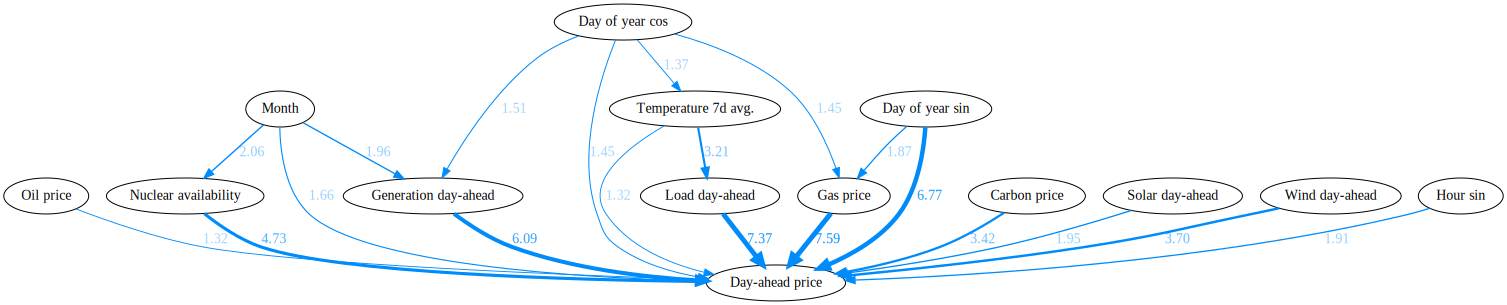

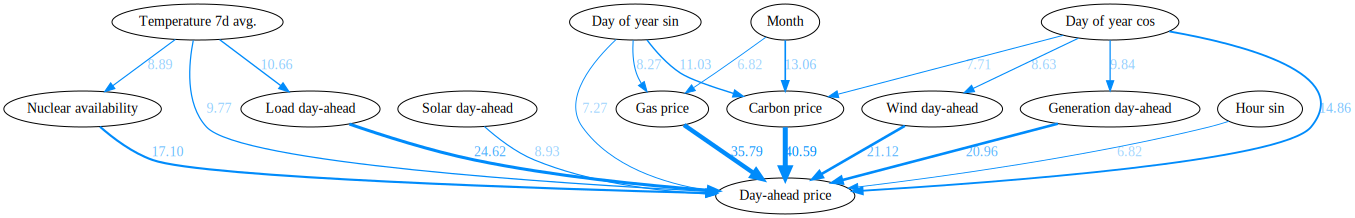

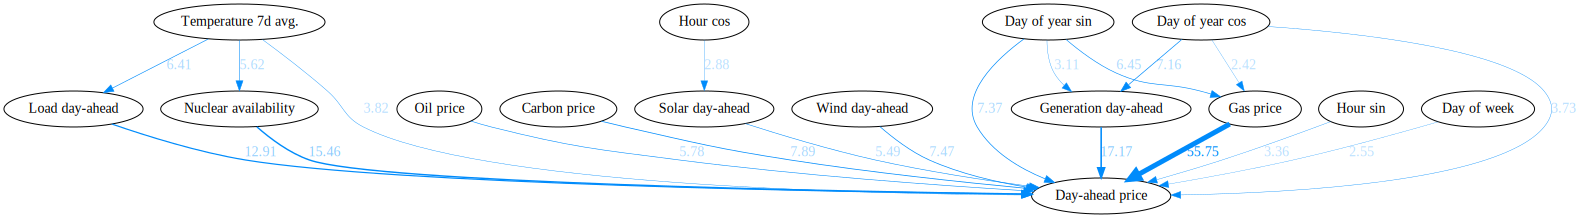

In [12]:
max_display = 20
for model_index in range(3):
    creditflow_list[model_index].fold_noise=True
    g = creditflow_list[model_index].draw(idx=-1,
                    show_fg_val=True,
                    max_display=max_display)
    start_date, end_date = periods[model_index]
    g.graph_attr['rankdir']='LR' # change layout from top-bottom to left-right
    save_graph_thesis(g, './plots/xgb_flow_mean-abs_show-{}_{}_{}_{}'.format(max_display, start_date, end_date, model_index), format='pdf', view=True)

### Mean absolute ASV

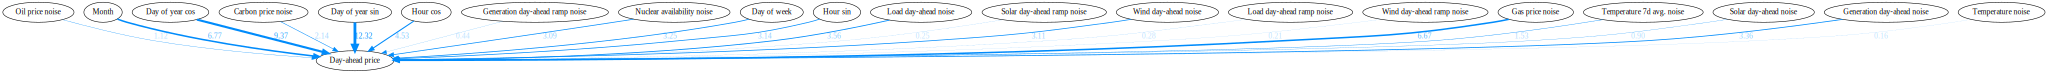

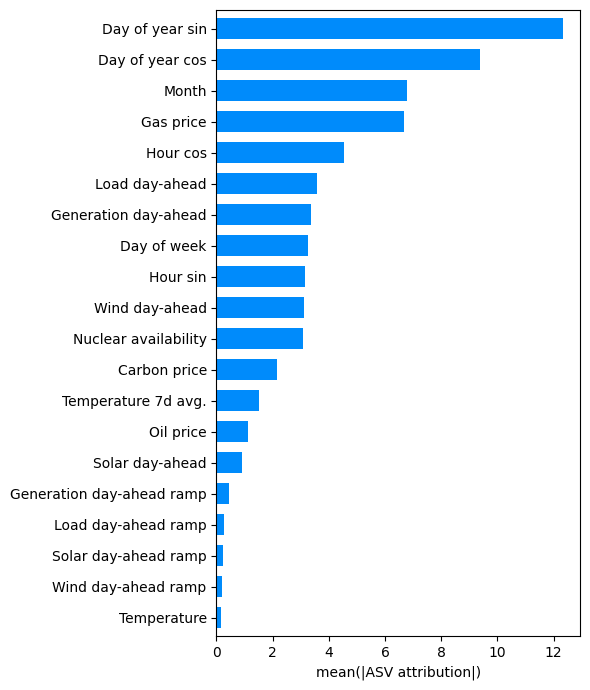

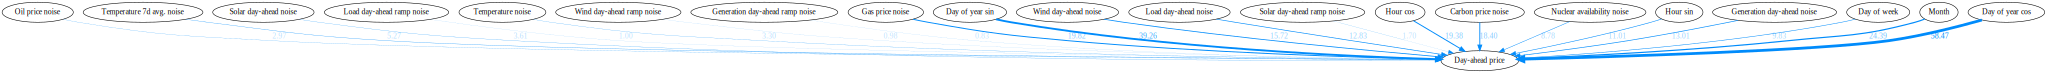

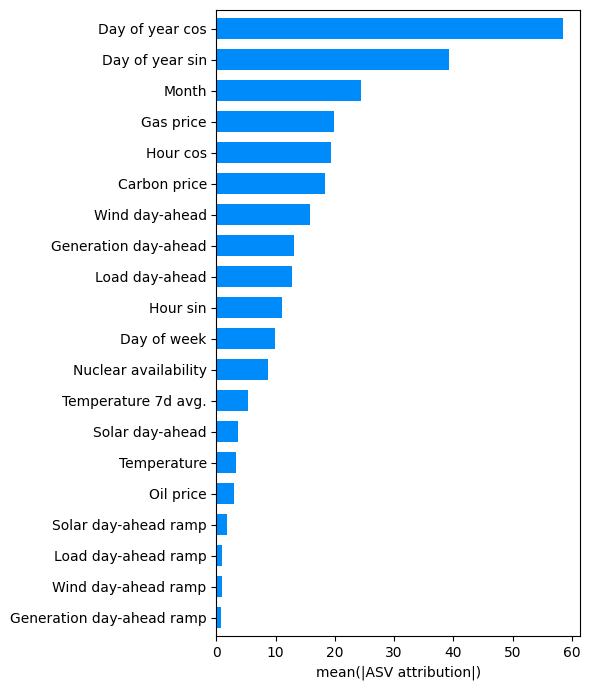

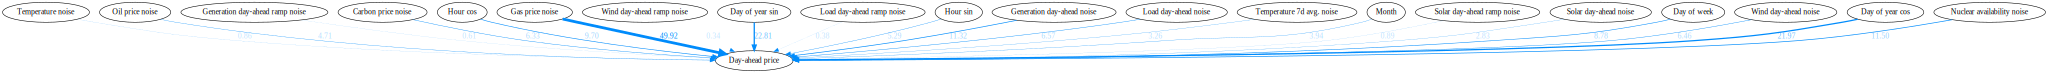

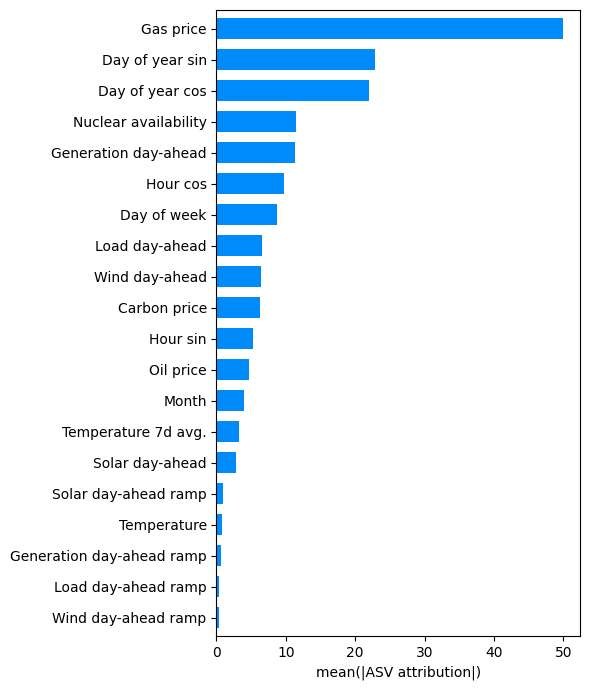

In [13]:
for i, period in enumerate(periods):
    start, end = period 
    plot_bar_mean_abs_asv(creditflow_list[i], figsize=(6, 7), save=True, name='{}_{}_{}_xgb'.format(start, end, i))

### Mean absolute SHAP (direct impact)

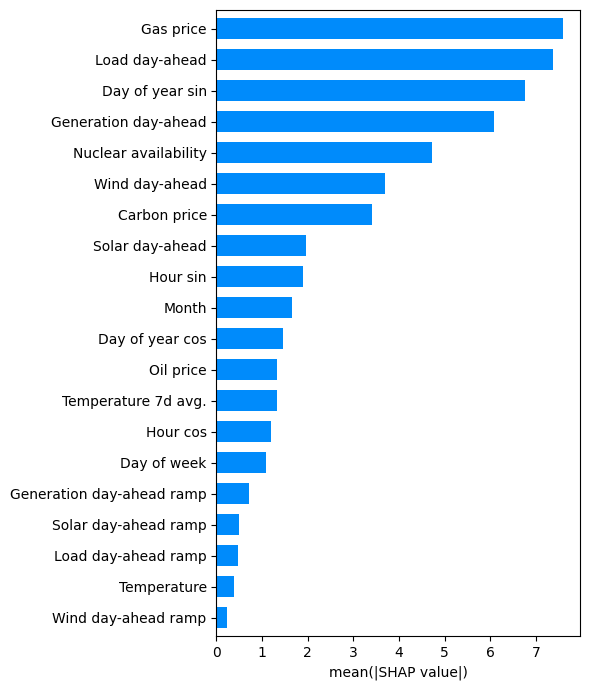

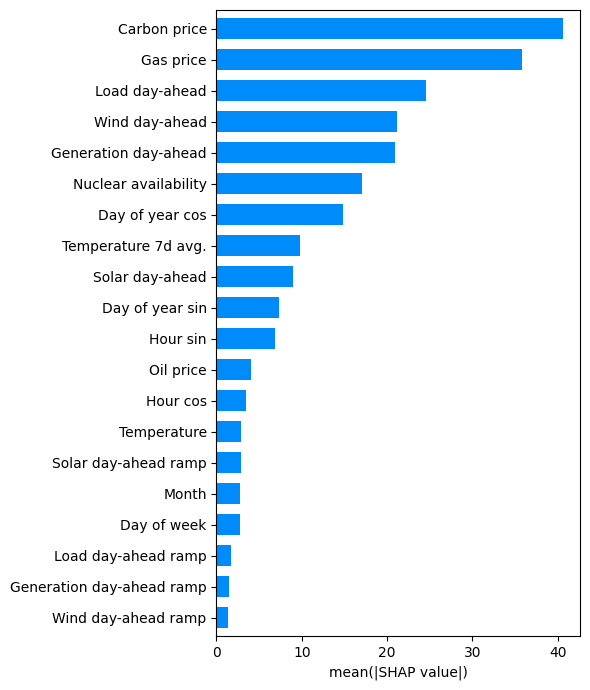

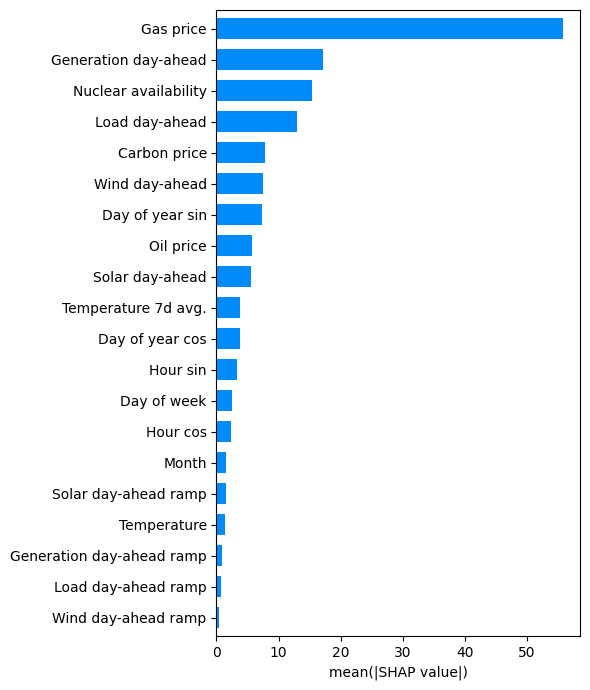

In [ ]:
for i, period in enumerate(periods):
    start, end = period 
    plot_bar_mean_abs_shap(creditflow_list[i], target='Day-ahead price', figsize=(6, 7), save=True, name='{}_{}_{}_xgb'.format(start, end, i))

### Compare SHAP for different models

In [42]:
df_feature_attr = pd.DataFrame()
for i, period in enumerate(periods):
    start, end = period
    col_name = 'XGB' + start + ' to ' + end
    df_feature_attr[col_name] = get_mean_shap_attr(creditflow_list[i], 'Day-ahead price')
    df_feature_attr[col_name] = df_feature_attr[col_name]/df_feature_attr[col_name].max()

new_order = ['Month', 'Day of week', 'Day of year cos', 'Day of year sin', 'Hour cos', 'Hour sin',
    'Generation day-ahead', 'Load day-ahead', 'Solar day-ahead', 'Wind day-ahead',
    'Generation day-ahead ramp', 'Load day-ahead ramp', 'Solar day-ahead ramp', 'Wind day-ahead ramp',
    'Nuclear availability', 'Temperature', 'Temperature 7d avg.',
    'Gas price', 'Oil price', 'Carbon price']

# Reindex the DataFrame
df_feature_attr = df_feature_attr.reindex(new_order)

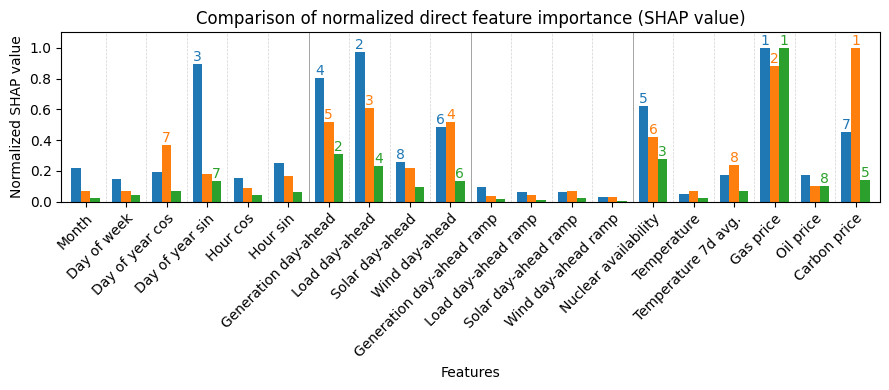

In [43]:
ax = df_feature_attr.plot(kind='bar', figsize=(9, 4), width=0.7)

plt.title("Comparison of normalized direct feature importance (SHAP value)")
plt.xlabel("Features")
plt.ylabel("Normalized SHAP value")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.legend(title="Time Periods")
ax.legend().remove()
plt.tight_layout()


ax.set_ylim(0, 1.1)

num_features = 8

for period in df_feature_attr.columns:
    top_features = df_feature_attr.nlargest(num_features, period)

    for feature_name in top_features.index:
        bar_index = list(df_feature_attr.index).index(feature_name)
        height = df_feature_attr.at[feature_name, period]
        feature_rank = top_features.index.get_loc(feature_name) + 1

        for container in ax.containers:
            if container.get_label() == period:
                bar = container[bar_index]
                bar_color = bar.get_facecolor()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), feature_rank, 
                        color=bar_color, ha='center', va='bottom', rotation=0, rotation_mode='anchor')

for i in range(len(df_feature_attr.index) - 1):
    if i in [5, 9, 13]:
        plt.axvline(x=i + 0.5, color='grey', linestyle='-', linewidth=0.5)
    else:
        plt.axvline(x=i + 0.5, color='lightgrey', linestyle='--', linewidth=0.5)

plt.show()

## Dependency plot

### model 0: Janury 2015 - September 2021

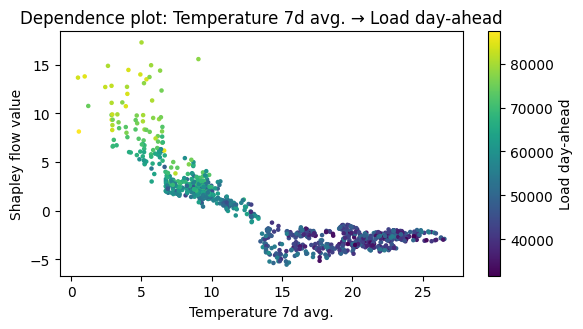

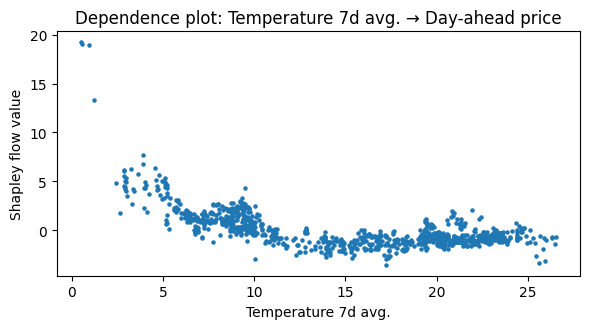

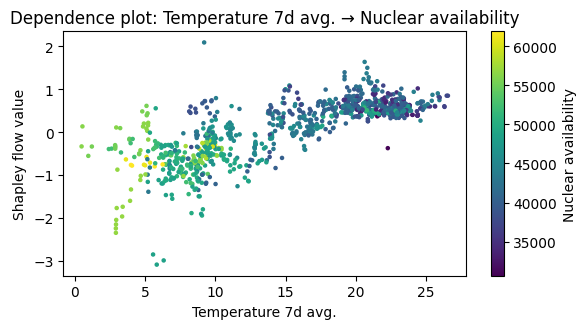

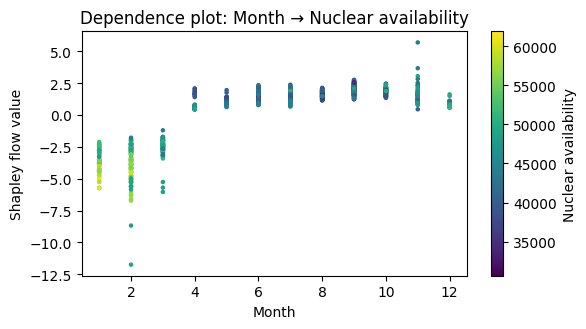

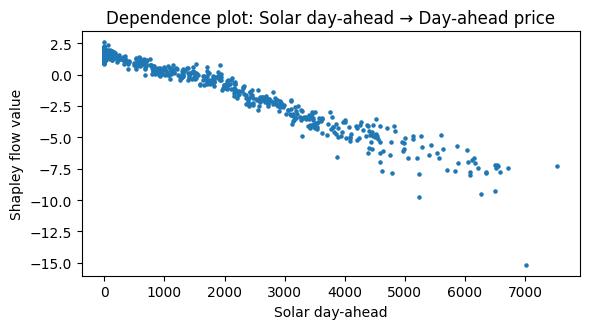

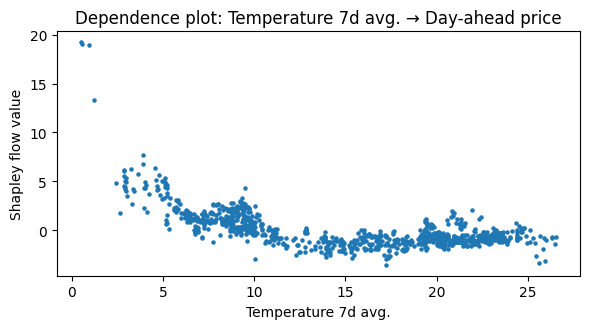

In [8]:
model_index = 0
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Month', 'Nuclear availability', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Solar day-ahead', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))

### model 1: October 2021 - December 2023

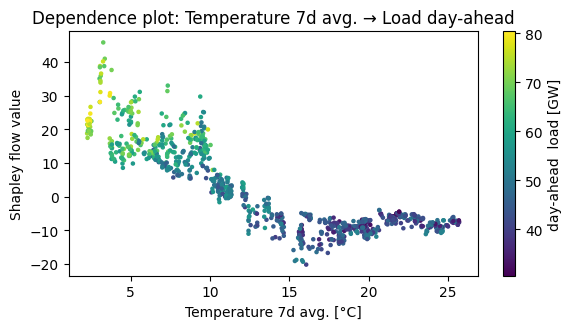

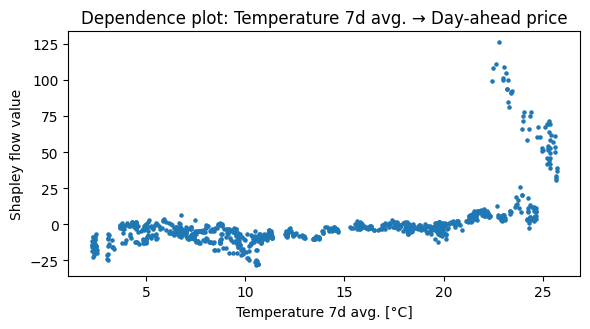

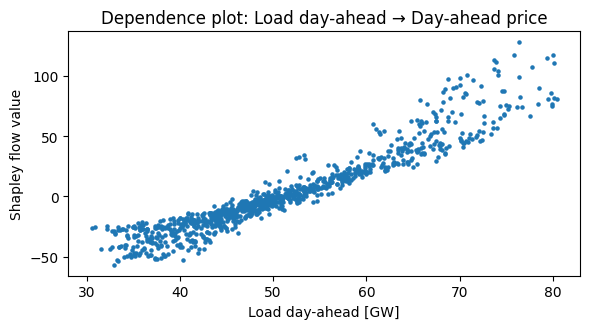

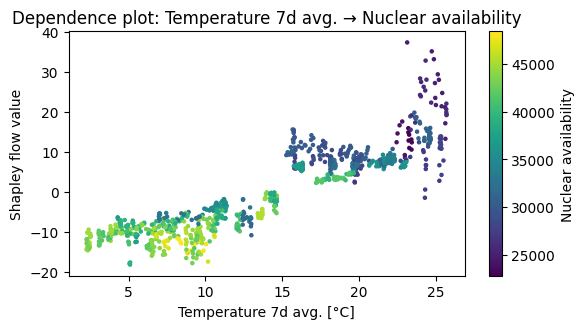

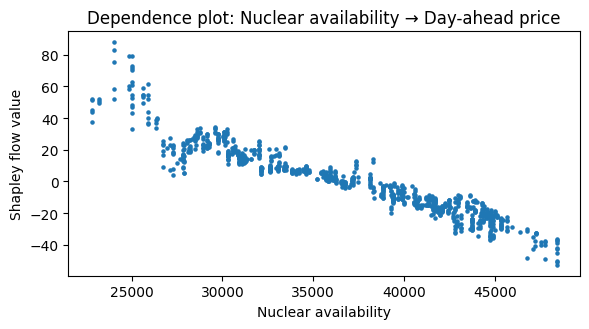

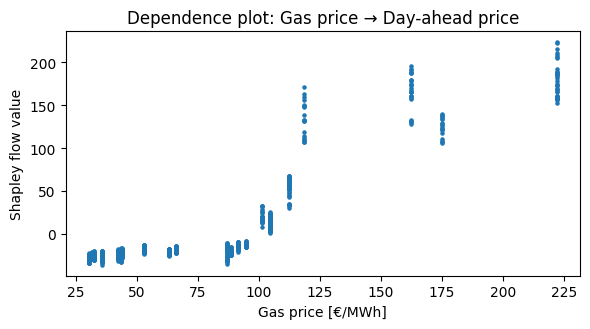

In [9]:
model_index = 1
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     x_label='Temperature 7d avg. [°C]', color_label='day-ahead  load [GW]',
                     scale_color=1000) # use scaling factor of 1000 for converting from MW to GW
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')
plot_dependency(cf, 'Load day-ahead', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), scale_x=1000, x_label='Load day-ahead [GW]')
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')
plot_dependency(cf, 'Nuclear availability', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Gas price', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                      x_label='Gas price [€/MWh]', scale_x=10)

### model 2: January 2015 - December 2023

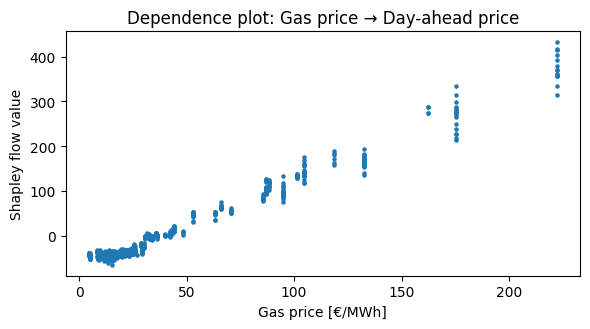

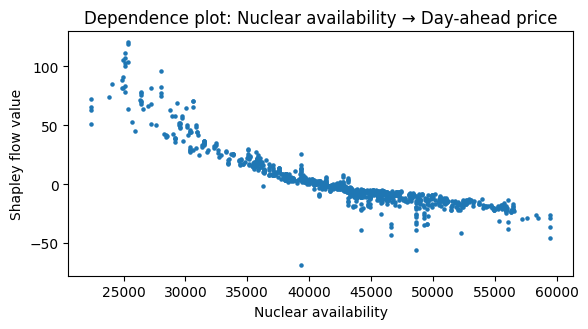

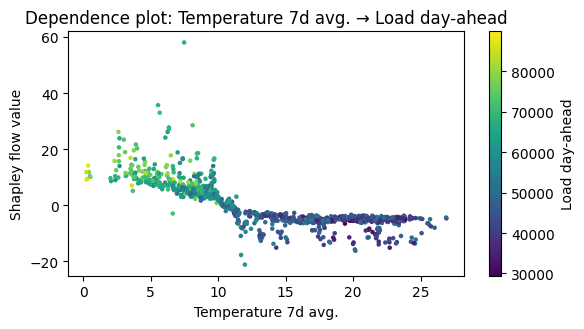

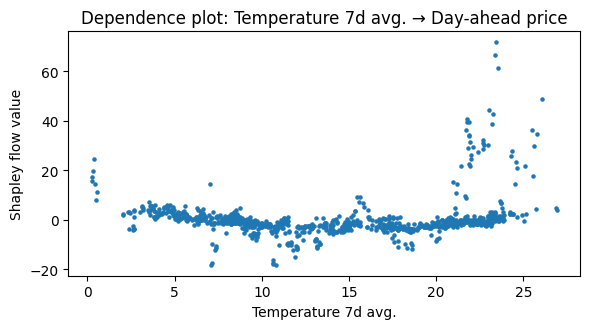

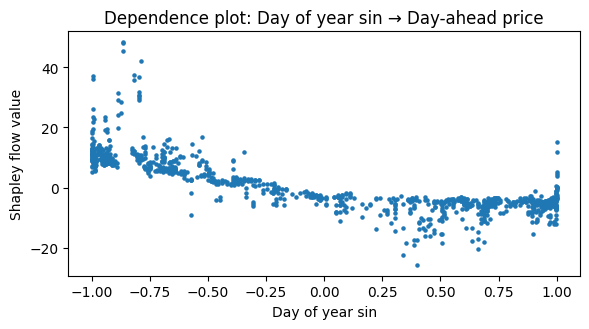

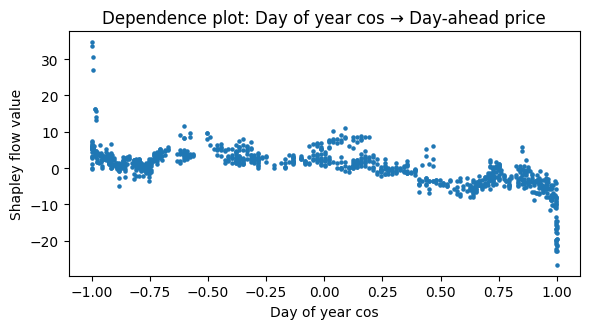

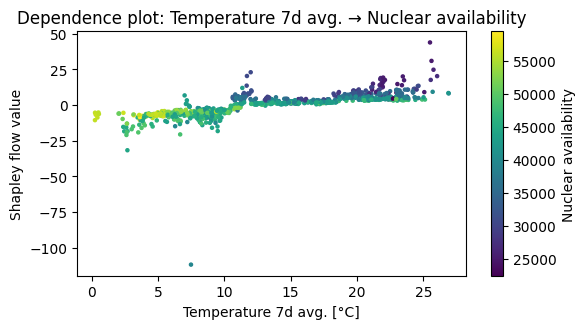

In [10]:
model_index = 2
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Gas price', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     y_label='Shapley flow value', x_label='Gas price [€/MWh]', scale_x=10)
plot_dependency(cf, 'Nuclear availability', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Day of year sin', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Day of year cos', 'Day-ahead price', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='xgb_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')

# Tree-SHAP (for reference)

## interventional

- requires background dataset (see documentation: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html)
- "true to the model"
- but explanations possibly based on "impossible data points"
- for a discussion see https://arxiv.org/abs/2006.16234

In [32]:
shap_values_list = []
for model_index in range(3):
    model = model_list[model_index]
    fg = fg_list[model_index]
    bg = bg_list[model_index]
    explainer = shap.TreeExplainer(model, data=bg, feature_perturbation='interventional')
    shap_values = explainer(fg)
    shap_values_list.append(shap_values)

 94%|=================== | 943/1000 [00:17<00:01]       

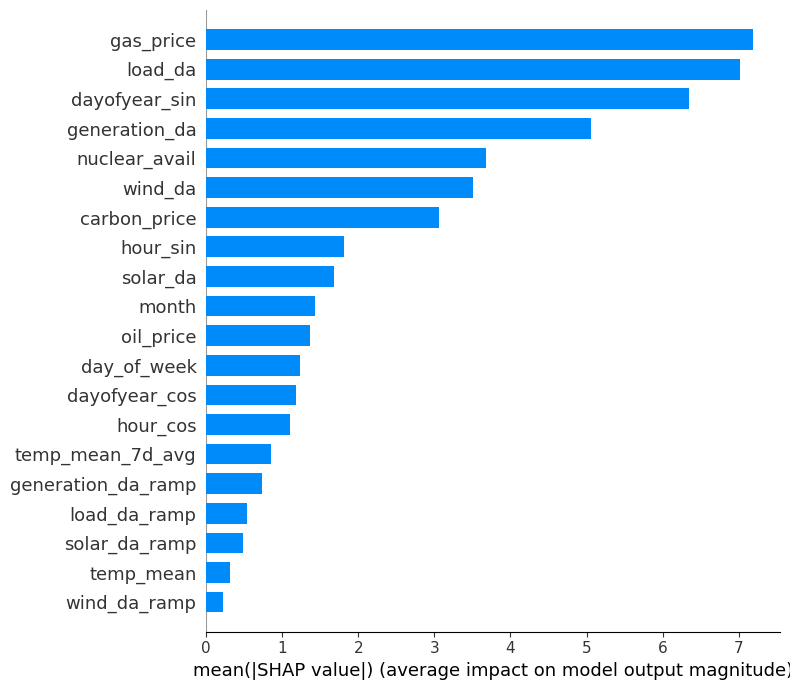

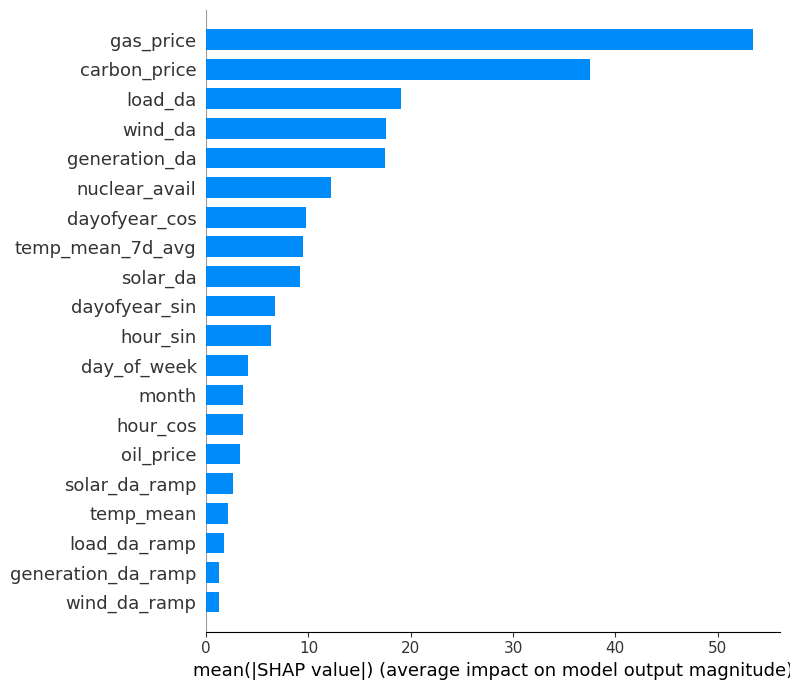

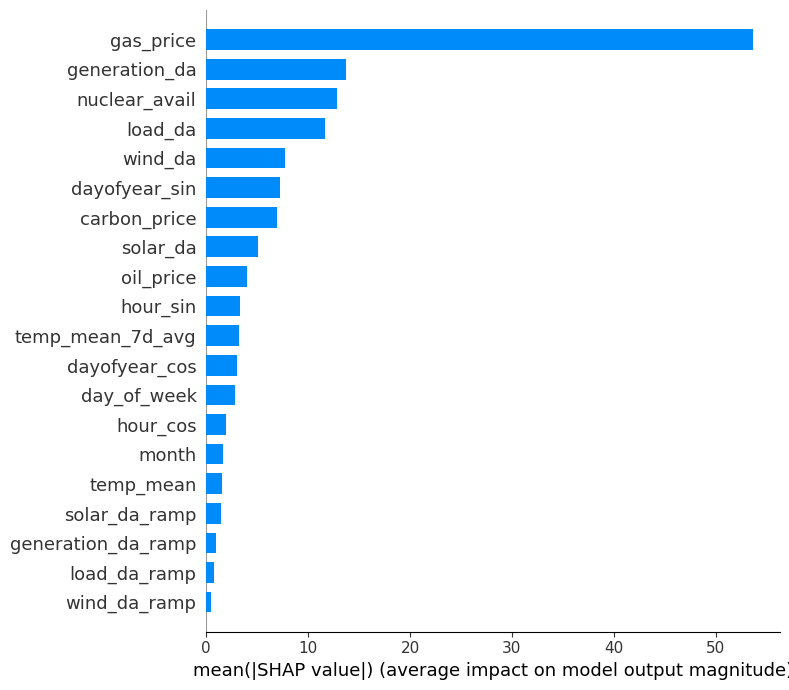

In [39]:
for shap_values in shap_values_list:
    shap.summary_plot(shap_values, plot_type='bar', plot_size=(8, 7))

## tree path dependent

- should be "true to the data" (approximately)

In [34]:
shap_values_list = []
for model_index in range(3):
    model = model_list[model_index]
    fg = fg_list[model_index]
    explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
    shap_values = explainer(fg)
    shap_values_list.append(shap_values)

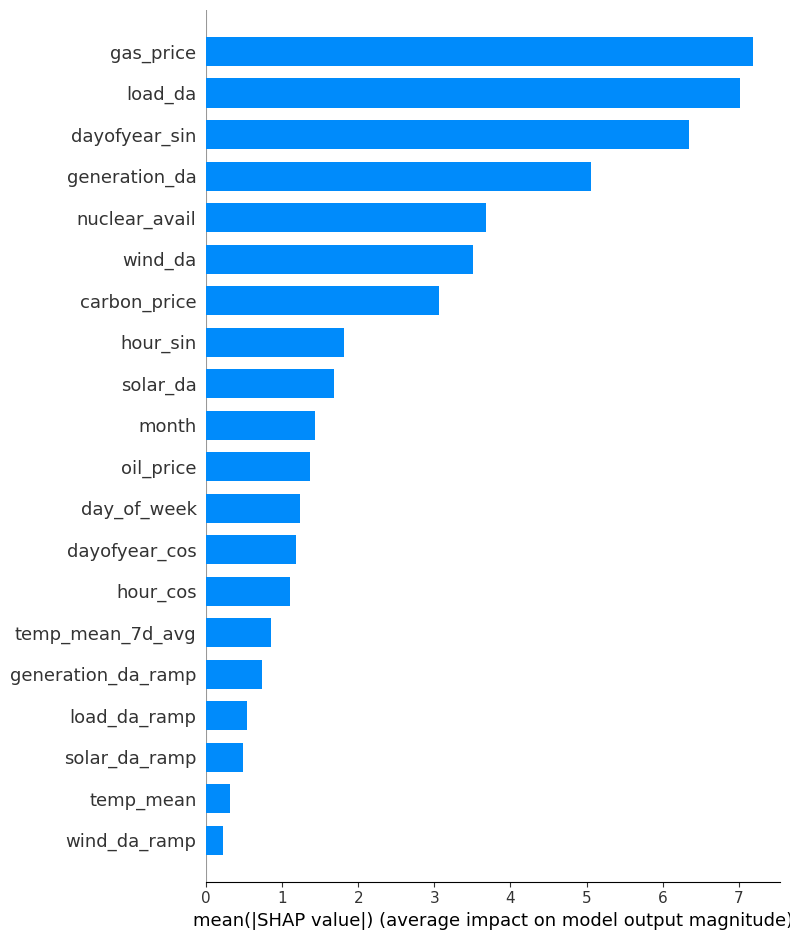

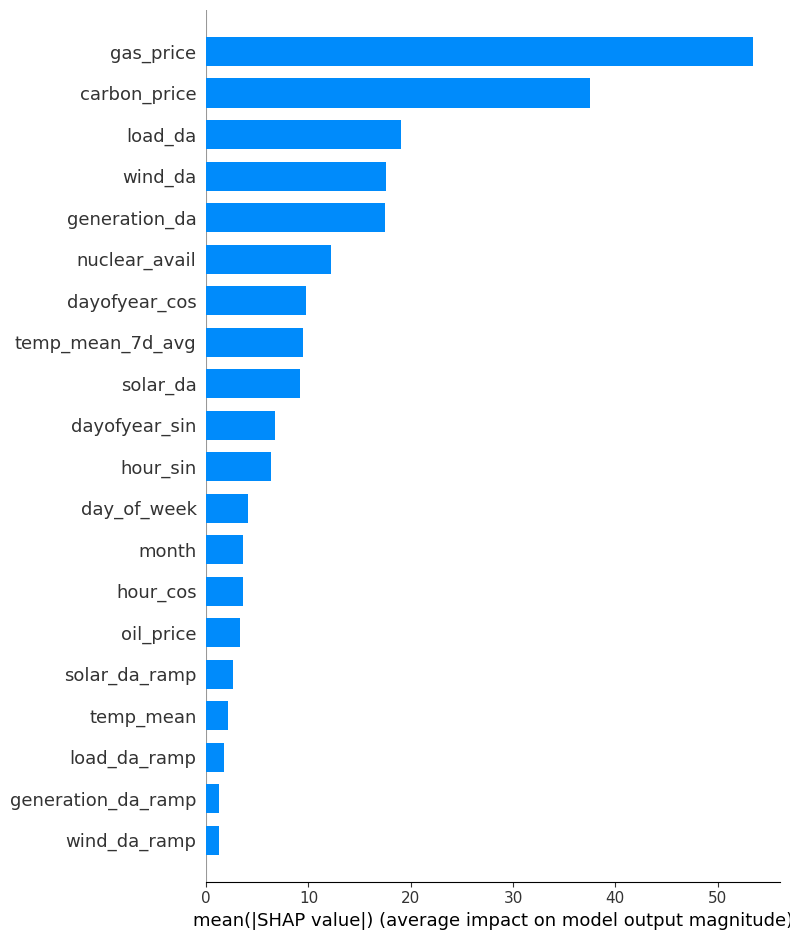

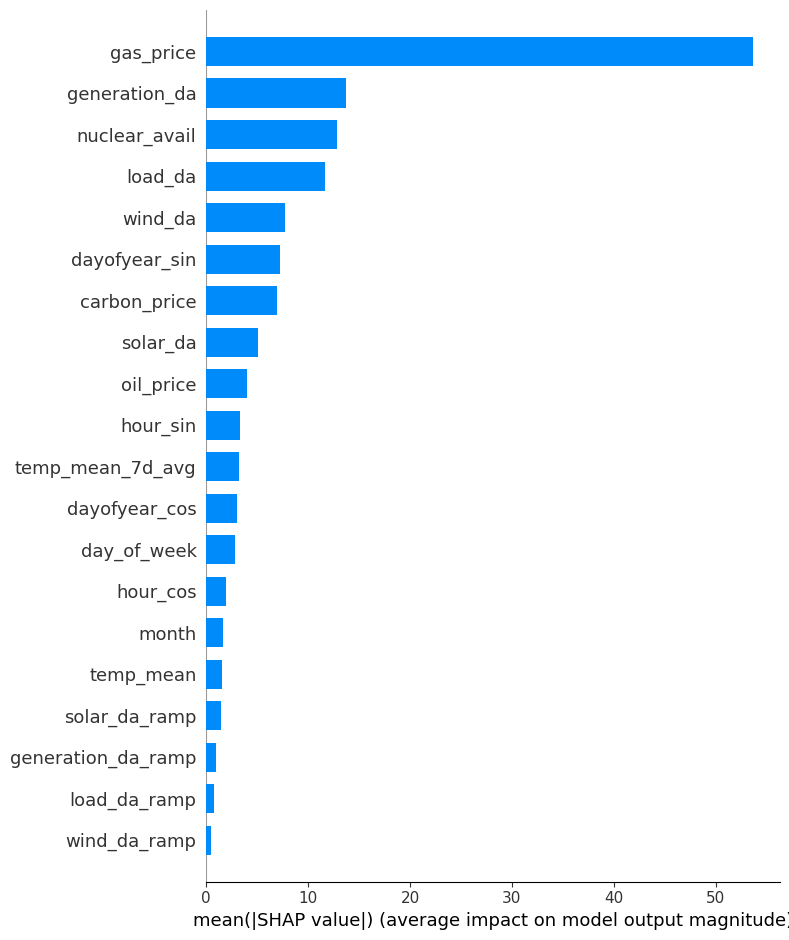

In [35]:
for shap_values in shap_values_list:
    shap.summary_plot(shap_values, plot_type='bar', plot_size=(8, 7))

# Model Evaluation

In [24]:
from shap_flow_util import read_csv_incl_timeindex

models = []
for (start_date, end_date) in periods:
    model = xgb.Booster()
    model_name = '/xgb_start_{}_end_{}_best'.format(start_date, end_date, version)
    model.load_model("./models/{}/{}.json".format(version, model_name))
    models.append(model)
    
    X_test = read_csv_incl_timeindex('./data/{}/X_test_xgb_start_{}_end_{}.csv'.format(version, start_date, end_date))
    y_test = read_csv_incl_timeindex('./data/{}/y_test_xgb_start_{}_end_{}.csv'.format(version, start_date, end_date))

    y_pred = pd.DataFrame(index=y_test.index)
    y_pred['xgb_pred'] = model.predict(xgb.DMatrix(X_test))
    r2_score_xgb = r2_score(y_test, y_pred['xgb_pred'])
    mae_xgb = mean_absolute_error(y_test, y_pred['xgb_pred'])
    mse_xgb = mean_squared_error(y_test, y_pred['xgb_pred'])
    print(start_date, end_date)
    print("R2: {:0.2f}".format(r2_score_xgb))
    print("MAE: {:0.2f}".format(mae_xgb))
    print("rmse: {:0.2f}".format(np.sqrt(mse_xgb)))
    print("(mean label: {:0.2f})".format(y_test['price_da'].mean()))
    print("------------------------------")


2015-01-08 2021-09-30
R2: 0.91
MAE: 4.71
rmse: 7.24
(mean label: 45.47)
------------------------------
2021-10-01 2023-12-31
R2: 0.80
MAE: 27.55
rmse: 67.88
(mean label: 187.00)
------------------------------
2015-01-08 2023-12-31
R2: 0.96
MAE: 10.81
rmse: 21.14
(mean label: 88.78)
------------------------------
